<a href="https://colab.research.google.com/github/microprediction/precise/blob/main/examples_colab_notebooks/weak_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade git+https://github.com/microprediction/precise.git

In [17]:
from precise.skaters.covarianceutil.covfunctions import cov_to_corrcoef, weaken_cov
from precise.skaters.locationutil.vectorfunctions import normalize
from precise.skaters.portfoliostatic.weakport import weak_long_port
from precise.skaters.portfoliostatic.unitport import unit_port
from precise.skaters.portfoliostatic.weakportfactory import _weak_from_cov
import numpy as np
from pprint import pprint 

# Weak Portfolios
A illustration

In [4]:
cov = np.array([[ 1.09948514, -1.02926114,  0.22402055,  0.10727343],
       [-1.02926114,  2.54302628,  1.05338531, -0.12481515],
       [ 0.22402055,  1.05338531,  1.79162765, -0.78962956],
       [ 0.10727343, -0.12481515, -0.78962956,  0.86316527]])

In [5]:
pprint(cov_to_corrcoef(cov))

array([[ 1.        , -0.61553885,  0.15961338,  0.11011602],
       [-0.61553885,  1.        ,  0.49350091, -0.08424515],
       [ 0.15961338,  0.49350091,  1.        , -0.63496903],
       [ 0.11011602, -0.08424515, -0.63496903,  1.        ]])


The minimum variance portfolio with weights summing to unity is well known to be proportional to precision multiplied by a vector of ones.  

In [6]:
pre = np.linalg.inv(cov)
w = normalize(np.dot(pre,np.ones(4)))
w

array([-9.00833504, -6.87125704,  8.74951879,  8.13007328])

Of course this is provided:

In [7]:
unit_port(cov)

array([-9.00833504, -6.87125704,  8.74951879,  8.13007328])

This can be dangerous, as you can see by the signs on the weights. Instead we can use: 

In [8]:
w1 = weak_long_port(cov=cov)
w1

array([0.06561497, 0.        , 0.36417362, 0.57021142])

This is called a weak portfolio because it is derived in pretty much the same way except that off-diag cov entries of some rows and columns have been multiplied by 0.976

In [27]:
dcov = np.diag(np.diag(cov))
off_diag_cov = cov-dcov
d_weak = 0.976*off_diag_cov + dcov
w2 = unit_port(d_weak)
w2

array([ 0.06744789, -0.00684143,  0.36581249,  0.57358106])

The "weak long portfolio" is then arrived at by removing negative mass and distributing it evenly. 

Now obviously the question to be asked here is ... why shrink off-diag covariances by 0.976 ?  Well... 

In [29]:
from precise.skaters.covarianceutil.covfunctions import try_invert, weaken_cov
from precise.skaters.portfoliostatic.unitportfactory import unitary_from_cov
from precise.skaters.portfolioutil.portfunctions import exclude_negative_weights, portfolio_variance

import scipy
from numpy.linalg import LinAlgError

v0 = portfolio_variance(cov=cov,w=w1)

def b_objective(u,w,a, v0):
    try:
        w1 = _weak_from_cov(cov, a=a, b=u[0], w=w, with_weak=False)
        v = portfolio_variance(cov=cov, w=exclude_negative_weights(w1))/v0
        return v
    except LinAlgError:
        bad_v = portfolio_variance(cov=cov, w=100*w)
        return bad_v

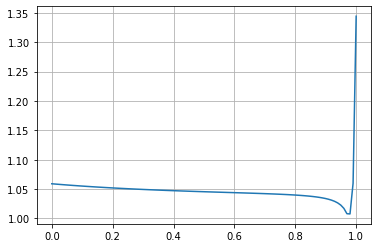

In [32]:
bs = np.linspace(0,1,100)
ys = [ b_objective([b],w1,1,v0) for b in bs ]
import matplotlib.pyplot as plt
plt.plot(bs,ys)
plt.grid()

What we are doing here is computing the portfolio variance of long-only portfolios achieved by shrinking off-diag cov entries and then redistributing negative mass, if any. 

We choose the shrinkage to minimize the portfolio variance, that is with respect to the original cov not the weakenned one.  